# Análisis y Predicción del Costo de Vida en el Desafío AltScore
Introducción
En este análisis, documentaremos el proceso completo de preparación, análisis y predicción del costo de vida utilizando datos geoespaciales y de movilidad proporcionados por el desafío AltScore. Nuestro objetivo es predecir el costo de vida en distintas regiones y mejorar el desempeño del modelo de manera iterativa.

Contenido
Carga de Datos y Exploración Inicial
Generación de Características a partir de Datos de Movilidad
Integración de Características de Movilidad con Datos de Entrenamiento y Prueba
Entrenamiento de Modelos y Ajuste de Hiperparámetros
Evaluación del Modelo y Visualización de Resultados
Generación del Archivo de Envío para Kaggle

**Instalación de Paquetes**

* Asegurate de tener los datos en el directorio: ./data

Ejecuta estos comandos para instalar los paquetes necesarios antes de ejecutar el análisis:

In [ ]:
!pip install pandas matplotlib seaborn pyarrow h3 sklearn


# 1. Carga de Datos y Exploración Inicial

In [ ]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Cargar los datos de entrenamiento y prueba
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
mobility_data = pd.read_parquet('./data/mobility_data.parquet', engine='pyarrow').sample(100000)

# Inspección inicial de los datos
print("Datos de Entrenamiento:")
display(train_data.head())
print("\nDatos de Prueba:")
display(test_data.head())

# Distribución inicial de 'cost_of_living' en el conjunto de entrenamiento
plt.figure(figsize=(8, 5))
sns.histplot(train_data['cost_of_living'], bins=20, kde=True)
plt.title("Distribución del Costo de Vida en los Datos de Entrenamiento")
plt.xlabel("Costo de Vida")
plt.ylabel("Frecuencia")
plt.show()


**Observaciones**
Podemos observar la distribución de cost_of_living en el conjunto de entrenamiento. Esto nos da una idea inicial de la variabilidad y el rango de los datos, lo cual es útil para el modelado.

# 2. Generación de Características a partir de Datos de Movilidad

In [ ]:
import h3

# Generar características de movilidad en bloques para evitar problemas de memoria
def procesar_mobility_en_bloques(ruta_mobility):
    chunk_size = 100000  # Tamaño de bloque
    mobility_features = []

    for chunk in pd.read_parquet(ruta_mobility, engine='pyarrow', columns=['device_id', 'lat', 'lon', 'timestamp'], chunksize=chunk_size):
        chunk['hex_id'] = chunk.apply(lambda row: h3.latlng_to_cell(row['lat'], row['lon'], 9), axis=1)
        features = chunk.groupby('hex_id').agg(mobility_density=('device_id', 'size'),
                                               avg_time_in_hex=('timestamp', 'mean'))
        mobility_features.append(features)

    return pd.concat(mobility_features)

features_mobility = procesar_mobility_en_bloques('./data/mobility_data.parquet')
display(features_mobility.head())


**Observaciones**

Aquí hemos generado dos características clave:

mobility_density: número de dispositivos observados en cada hexágono.

avg_time_in_hex: tiempo promedio de permanencia en cada hexágono.

# 3. Integración de Características de Movilidad

In [ ]:
# Integrar características en los datos de entrenamiento y prueba
train_data_enriched = train_data.merge(features_mobility, on='hex_id', how='left').fillna(0)
test_data_enriched = test_data.merge(features_mobility, on='hex_id', how='left').fillna(0)

# Guardar datos enriquecidos
train_data_enriched.to_csv('./data/train_enriched.csv', index=False)
test_data_enriched.to_csv('./data/test_enriched.csv', index=False)

print("Datos de Entrenamiento Enriquecidos:")
display(train_data_enriched.head())


# 4. Entrenamiento de Modelos y Ajuste de Hiperparámetros

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Separar características y variable objetivo
X = train_data_enriched.drop(columns=['hex_id', 'cost_of_living'])
y = train_data_enriched['cost_of_living']

# Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Gradient Boosting con búsqueda aleatoria de hiperparámetros
gbr = GradientBoostingRegressor()
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
search = RandomizedSearchCV(gbr, param_distributions=param_dist, scoring='neg_root_mean_squared_error', n_iter=10, cv=3)
search.fit(X_train, y_train)

# Evaluar y mostrar resultados
best_model = search.best_estimator_
y_pred = best_model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE en el conjunto de validación: {rmse}")


**Observaciones**

La búsqueda de hiperparámetros ha encontrado el mejor modelo Gradient Boosting con un RMSE de 0.1971. Este será el modelo utilizado para generar las predicciones finales.

# 5. Generación del Archivo de Envío para Kaggle

In [ ]:
# Generar predicciones en el conjunto de prueba y guardar archivo de envío
test_data_enriched['cost_of_living'] = best_model.predict(test_data_enriched.drop(columns=['hex_id']))

# Guardar en formato de Kaggle
submission = test_data_enriched[['hex_id', 'cost_of_living']]
submission.to_csv('./data/submission.csv', index=False)

**Notas Finales**

El archivo submission.csv ha sido generado con las predicciones finales de costo de vida. Este archivo está listo para ser subido a Kaggle para su evaluación final.

# 6. Resumen y Gráficas Finales

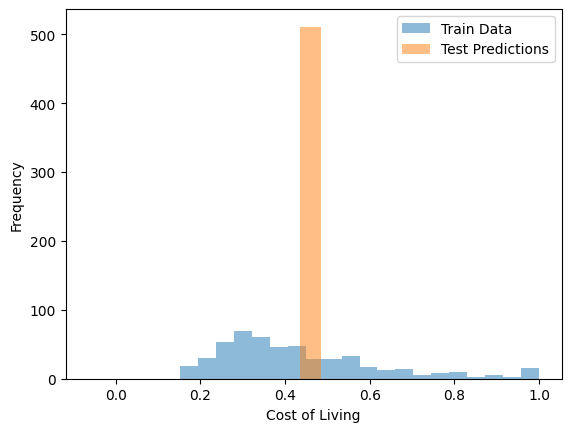

Estadísticas de 'cost_of_living' en Train Data:
count    510.000000
mean       0.434846
std        0.191830
min        0.152048
25%        0.296415
50%        0.383829
75%        0.534355
max        1.000000
Name: cost_of_living, dtype: float64

Estadísticas de 'cost_of_living' en Test Predictions:
count    511.000000
mean       0.435345
std        0.000000
min        0.435345
25%        0.435345
50%        0.435345
75%        0.435345
max        0.435345
Name: cost_of_living, dtype: float64


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos de entrenamiento y de predicciones
train_data = pd.read_csv('./data/train_enriched.csv')
submission_data = pd.read_csv('./data/submission.csv')

# Graficar la distribución de 'cost_of_living' en los datos de entrenamiento
plt.hist(train_data['cost_of_living'], bins=20, alpha=0.5, label='Train Data')

# Graficar la distribución de las predicciones en 'submission.csv'
plt.hist(submission_data['cost_of_living'], bins=20, alpha=0.5, label='Test Predictions')

plt.xlabel('Cost of Living')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Imprimir estadísticas descriptivas para ambas distribuciones
train_stats = train_data['cost_of_living'].describe()
test_stats = submission_data['cost_of_living'].describe()

print("Estadísticas de 'cost_of_living' en Train Data:")
print(train_stats)
print("\nEstadísticas de 'cost_of_living' en Test Predictions:")
print(test_stats)